In [1]:
#DeterministicScoreCard


In [2]:
#ScoreCard IFS HRES IFS ENS MEAN
#Fuxi vs ENS Mean some of the better models up to lag 40, 64x32
#Fuxi initial conditions were ERA5, wheras ENS mean were Analysis/Operational
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm
#import Functions as fu
import line_profiler
from datetime import datetime, timedelta
from multiprocessing import Pool, cpu_count
import time
from weatherbench2.metrics import MSE, ACC
from weatherbench2.regions import SliceRegion
import seaborn as sns
from dateutil.relativedelta import relativedelta
import ScorecardFunctions as SCF





In [3]:
import apache_beam

In [4]:
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
observationsera = xr.open_zarr(obs_path)
observationsera

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [5]:
climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_conservative.zarr'
climatology = xr.open_zarr(climatology_path)
climatology

<xarray.Dataset>
Dimensions:                                         (hour: 4, dayofyear: 366,
                                                     longitude: 64,
                                                     latitude: 32, level: 13)
Coordinates:
  * dayofyear                                       (dayofyear) int64 1 ... 366
  * hour                                            (hour) int64 0 6 12 18
  * latitude                                        (latitude) float64 -87.19...
  * level                                           (level) int64 50 ... 1000
  * longitude                                       (longitude) float64 0.0 ....
Data variables: (12/53)
    10m_u_component_of_wind                         (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                         (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_wind_speed                                  (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    2m_dewpoint_temperature                         (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    2m_temperature                                  (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    above_ground                                    (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    ...                                              ...
    volumetric_soil_water_layer_1                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_2                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_3                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_4                   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    vorticity                                       (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    wind_speed                                      (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>

In [6]:
#IFS ENS mean
forecast2 = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')
forecast2
#12 Hour increments, pred 6 Hours #61

<xarray.Dataset>
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -87.19 -81.56 ... 81.56 87.19
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [7]:
#Fuxi
forecast11 = xr.open_zarr('gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr')
forecast11
#12 Hour increments, pred 6 Hours #60, no time 0

<xarray.Dataset>
Dimensions:                            (time: 702, prediction_timedelta: 60,
                                        longitude: 64, latitude: 32, level: 2)
Coordinates:
  * latitude                           (latitude) float64 -87.19 ... 87.19
  * level                              (level) int32 500 850
  * longitude                          (longitude) float64 0.0 5.625 ... 354.4
  * prediction_timedelta               (prediction_timedelta) timedelta64[ns] ...
  * time                               (time) datetime64[ns] 2020-01-01 ... 2...
Data variables:
    10m_u_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_wind_speed                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    2m_temperature                     (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    geopotential                       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    temperature                        (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    total_precipitation_24hr_from_6hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    total_precipitation_6hr            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    u_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    v_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    wind_speed                         (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>

In [8]:
startdate = {0:'2020-01-01',1:'2020-02-01',2:'2020-03-01',3:'2020-04-01',4:'2020-05-01',5:'2020-06-01',6:'2020-07-01',7:'2020-08-01',8:'2020-09-01',9:'2020-10-01',10:'2020-11-01',11:'2020-12-01'}
enddate = {0:'2020-01-03',1:'2020-02-03',2:'2020-03-03',3:'2020-04-03',4:'2020-05-03',5:'2020-06-03',6:'2020-07-03',7:'2020-08-03',8:'2020-09-03',9:'2020-10-03',10:'2020-11-03',11:'2020-12-03'}

In [9]:
overallIFSENSE = xr.open_dataset('./IFSCard/ENSERAmonths11.nc')
for i in range(11):
    results = xr.open_dataset('./IFSCard/ENSERAmonths' + str(i) + '.nc')
    overallIFSENSE = overallIFSENSE + results

overallIFSENSE = overallIFSENSE/12
overallIFSENSE = overallIFSENSE.isel(lead_time=slice(1, None))

overallFUXI = xr.open_dataset('./FUXICard/FUXImonths11.nc')
for i in range(11):
    results = xr.open_dataset('./FUXICard/FUXImonths' + str(i) + '.nc')
    overallFUXI = overallFUXI + results

overallFUXI = overallFUXI/12

In [10]:
percentage_diff = (overallFUXI - overallIFSENSE) / overallIFSENSE * 100
percentage_diff

<xarray.Dataset>
Dimensions:         (lead_time: 60, region: 3, metric: 2, level: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 06:00:00 ... 15 days 0...
  * region          (region) object 'northernhemisphere' ... 'southernhemisph...
  * metric          (metric) object 'acc' 'mse'
  * level           (level) int32 500 850
Data variables:
    geopotential    (metric, region, lead_time, level) float64 0.02242 ... -0...
    temperature     (metric, region, lead_time, level) float64 0.1149 ... 5.72
    2m_temperature  (metric, region, lead_time) float64 2.43 3.693 ... 4.582
    10m_wind_speed  (metric, region, lead_time) float64 0.5467 0.4789 ... 189.9

In [11]:
for var in percentage_diff.data_vars:
    if 'metric' in percentage_diff[var].dims:
        percentage_diff[var].loc[dict(metric='acc')] *= -1

In [12]:

geopotential = percentage_diff['geopotential'].values
geopotential.shape #now have normal array(metric =2, region =3, leadtime = 60, level =2)

temperature = percentage_diff['temperature'].values
m2_temperature = percentage_diff['2m_temperature'].values
m10_wind_speed = percentage_diff['10m_wind_speed'].values

In [13]:
forecast2 = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')
forecast2
forecast2 = forecast2.sel(prediction_timedelta=forecast2.prediction_timedelta != np.timedelta64(0, 'D'))

In [65]:
# def timecuttingmonthly(obsxarray,forsxarray, days, predtimedelta, month,variableval,levelval,region):
#     if region == 'Tropics':
#         latslice = slice(-20, 20)
#     elif region == 'Northern':
#         latslice = slice(20, 90)
#     else:
#         latslice = slice(-90, -20)

#     startdate = datetime(2020,month+1,1)
#     newdate = datetime(2020,month+1,days,12)
#     obsnewdate = newdate + timedelta(hours = (predtimedelta-1)*6)
    
#     if levelval == 0:
#         return obsxarray[variableval].sel(time = slice(startdate, obsnewdate), latitude = latslice), forsxarray[variableval].sel(time = slice(startdate, newdate), latitude = latslice), 
#     else:
#         return obsxarray[variableval].sel(level = levelval, time = slice(startdate, obsnewdate), latitude = latslice), forsxarray[variableval].sel(level = levelval, time = slice(startdate, newdate), latitude = latslice), 

In [14]:
# testob, testfo = timecuttingmonthly(observationsera, forecast2, days=3,predtimedelta =61, month=1,variableval = 'geopotential',levelval =500,region = 'Northern')
# #Tropics have 8
# #Northern have 12
# #Southern have 12
# print(testob.values.shape) #69,64,32
# print(testfo.values.shape) #5, 60,64,32 


TypeError: timecuttingmonthly() got an unexpected keyword argument 'region'

In [ ]:
#testob #Always lower to higher latslices

<xarray.DataArray 'geopotential' (time: 71, longitude: 64, latitude: 12)>
dask.array<getitem, shape=(71, 64, 12), dtype=float32, chunksize=(56, 64, 12), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 25.31 30.94 36.56 42.19 ... 75.94 81.56 87.19
    level      int64 500
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2020-02-01 ... 2020-02-18T12:00:00
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [ ]:
#12 months
#Three regions
#Four variables, two with 2 levels, two with 1, six total
#18

In [14]:
def timecuttingmonthly(obsxarray,forsxarray, days, predtimedelta, month,variableval,levelval):
    startdate = datetime(2020,month+1,1)
    newdate = datetime(2020,month+1,days,12)
    obsnewdate = newdate + timedelta(hours = (predtimedelta-1)*6)
    
    if levelval == 0:
        return obsxarray[variableval].sel(time = slice(startdate, obsnewdate)), forsxarray[variableval].sel(time = slice(startdate, newdate)), 
    else:
        return obsxarray[variableval].sel(level = levelval, time = slice(startdate, obsnewdate)), forsxarray[variableval].sel(level = levelval, time = slice(startdate, newdate)), 


In [15]:
obs, fo = SCF.timecuttingmonthly(observationsera, forecast11, 3, 60+1, 0, 'geopotential', 500)

In [34]:
obs

<xarray.DataArray 'geopotential' (time: 71, longitude: 64, latitude: 32)>
dask.array<getitem, shape=(71, 64, 32), dtype=float32, chunksize=(71, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
    level      int64 500
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-01-18T12:00:00
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [14]:
fo

<xarray.DataArray 'geopotential' (time: 6, prediction_timedelta: 60,
                                  longitude: 64, latitude: 32)>
dask.array<getitem, shape=(6, 60, 64, 32), dtype=float32, chunksize=(4, 60, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
    level                 int32 500
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days 06:00...
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-03T12:...

In [16]:
obs1, fo1 = SCF.timecuttingmonthly(observationsera, forecast2, 3, 60+1, 0, 'geopotential', 500)

In [17]:
def timecuttingmonthly(obsxarray,forsxarray, days, predtimedelta, month,variableval,levelval):
    startdate = datetime(2020,month+1,1)
    newdate = datetime(2020,month+1,days,12)
    obsnewdate = newdate + timedelta(hours = (predtimedelta-1)*6)
    
    if levelval == 0:
        return obsxarray[variableval].sel(time = slice(startdate, obsnewdate)), forsxarray[variableval].sel(time = slice(startdate, newdate)), 
    else:
        return obsxarray[variableval].sel(level = levelval, time = slice(startdate, obsnewdate)), forsxarray[variableval].sel(level = levelval, time = slice(startdate, newdate)), 


In [18]:
startdate = {0:'2020-01-01',1:'2020-02-01',2:'2020-03-01',3:'2020-04-01',4:'2020-05-01',5:'2020-06-01',6:'2020-07-01',7:'2020-08-01',8:'2020-09-01',9:'2020-10-01',10:'2020-11-01',11:'2020-12-01'}
enddate = {0:'2020-01-03',1:'2020-02-03',2:'2020-03-03',3:'2020-04-03',4:'2020-05-03',5:'2020-06-03',6:'2020-07-03',7:'2020-08-03',8:'2020-09-03',9:'2020-10-03',10:'2020-11-03',11:'2020-12-03'}

In [36]:
fo1

<xarray.DataArray 'geopotential' (time: 6, prediction_timedelta: 60,
                                  longitude: 64, latitude: 32)>
dask.array<getitem, shape=(6, 60, 64, 32), dtype=float32, chunksize=(4, 1, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
    level                 int32 500
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days 06:00...
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-03T12:...
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [15]:
distance = SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = 0, variableval = 'geopotential', levelval = 500, region = "Tropics")
#Should be able to do global at same time

12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]


In [16]:
distance.shape #lat slices, time, initial, 3

(32, 6, 60, 3)

In [19]:
weights = np.array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

southernweights = weights[0:12]
tropicweights = weights[12:20]
northernweights = weights[20:32]

In [39]:
print(weights[0:12])

[0.07704437 0.23039114 0.38151911 0.52897285 0.67133229 0.80722643
 0.93534654 1.05445875 1.16341595 1.26116882 1.34677594 1.41941287]


In [ ]:
# pkarraylat = np.sum(pkarray * usedweights[:, None, None, None], axis=0)
#     # pktime = np.mean(pkarraylat, axis=0)
#     # distance = pktime[:, 1] + pktime[:, 2] - 2 * pktime[:, 0]

In [20]:
def workflowfullparallelmonthly(observations, forecasts, days, lag,zero, month, variableval,levelval, region):        
    ob, fo = timecuttingmonthly(observations,forecasts,days,lag+zero,month, variableval,levelval)
    ob = ob.values
    fo = fo[:,0:lag,:,:].values
    ob, fo = scalebyobsadjusted(ob,fo,fo.shape[2])
    pkarray = pkparallel(ob,fo,zero,region) #, pkarraylat, distance, score

    return (pkarray)

In [18]:
geo500 = np.zeros((32,6,60,3))
for monthval in range(12):
    geo500 +=SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'geopotential', levelval = 500, region = "Doesn't matter")


12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6)

In [19]:
np.save('Newresults/geo500.npy', geo500)

In [21]:
def latsplit(input):
    inputsouthern = np.sum(input[0:12,:,:,:] * southernweights[:, None, None, None], axis=0)
    inputst = np.mean(inputsouthern, axis=0)
    inputsoutherndistance = inputst[:, 1] + inputst[:, 2] - 2 * inputst[:, 0]

    inputtropic = np.sum(input[12:20,:,:,:] * tropicweights[:, None, None, None], axis=0)
    inputtt = np.mean(inputtropic, axis=0)
    inputtropicdistance = inputtt[:, 1] + inputtt[:, 2] - 2 * inputtt[:, 0]

    inputnorthern = np.sum(input[20:32,:,:,:] * northernweights[:, None, None, None], axis=0)
    inputnt = np.mean(inputnorthern, axis=0)
    inputnortherndistance = inputnt[:, 1] + inputnt[:, 2] - 2 * inputnt[:, 0]

    return (inputsoutherndistance,inputtropicdistance,inputnortherndistance)



In [21]:
geo500

array([[[[  0.        ,   0.        ,   0.        ],
         [ 57.40688398,  57.36493065,  57.50052073],
         [ 65.12464061,  65.0627197 ,  65.263398  ],
         ...,
         [ 94.93801387,  98.06564621, 106.21991622],
         [ 94.77765165,  98.12366958, 106.69778029],
         [ 94.58621292,  98.08856104, 106.84440429]],

        [[  0.        ,   0.        ,   0.        ],
         [ 57.29072651,  57.27225185,  57.36161797],
         [ 64.92910831,  64.90763746,  65.01905463],
         ...,
         [ 97.37330211, 101.34428305, 108.38310692],
         [ 97.32303569, 101.4433189 , 108.72688513],
         [ 97.29765876, 101.48271869, 109.058548  ]],

        [[  0.        ,   0.        ,   0.        ],
         [ 57.19123865,  57.16400971,  57.25355129],
         [ 64.92752846,  64.89434203,  65.00306951],
         ...,
         [ 99.10579602, 102.36163922, 110.17016215],
         [ 99.23560413, 102.39188862, 110.33069939],
         [ 99.17556937, 102.37476753, 110.14338852]],

In [22]:
south, tropics, northern = latsplit(geo500)
south

array([0.00000000e+00, 1.06150662e-01, 1.57934710e-01, 2.82480803e-01,
       3.89370251e-01, 6.10033881e-01, 8.29064505e-01, 1.20318978e+00,
       1.58733281e+00, 2.18258038e+00, 2.79551779e+00, 3.71421479e+00,
       4.65283916e+00, 5.96636761e+00, 7.35485442e+00, 9.23573483e+00,
       1.12022106e+01, 1.37140294e+01, 1.63190660e+01, 1.95877576e+01,
       2.28990104e+01, 2.69185013e+01, 3.09622650e+01, 3.57648407e+01,
       4.05625793e+01, 4.62148407e+01, 5.20031944e+01, 5.87368721e+01,
       6.55147396e+01, 7.32433054e+01, 8.09907581e+01, 8.97986409e+01,
       9.83025615e+01, 1.07360579e+02, 1.15958731e+02, 1.25155295e+02,
       1.34009026e+02, 1.43593653e+02, 1.52811599e+02, 1.62668973e+02,
       1.72178134e+02, 1.82446439e+02, 1.92409543e+02, 2.03146308e+02,
       2.13394898e+02, 2.24505796e+02, 2.34889471e+02, 2.46200281e+02,
       2.56565470e+02, 2.67606458e+02, 2.77572314e+02, 2.88277451e+02,
       2.98049021e+02, 3.08702613e+02, 3.18321104e+02, 3.28934156e+02,
      

In [23]:
geo850 = np.zeros((32,6,60,3))
for monthval in range(12):
    geo850 = geo850 + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'geopotential', levelval = 850, region = "Doesn't matter")
np.save('Newresults/geo850.npy', geo850)

temp500 = np.zeros((32,6,60,3))
for monthval in range(12):
    temp500 = temp500 + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'temperature', levelval = 500, region = "Doesn't matter")
np.save('Newresults/temp500.npy', temp500)

temp850 = np.zeros((32,6,60,3))
for monthval in range(12):
    temp850 = temp850 + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'temperature', levelval = 850, region = "Doesn't matter")
np.save('Newresults/temp850.npy', temp850)

temp2m = np.zeros((32,6,60,3))
for monthval in range(12):
    temp2m = temp2m + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = '2m_temperature', levelval = 0, region = "Doesn't matter")
np.save('Newresults/temp2m.npy', temp2m)

wind10m = np.zeros((32,6,60,3))
for monthval in range(12):
    wind10m = wind10m + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = '10m_wind_speed', levelval = 0, region = "Doesn't matter")
np.save('Newresults/wind10m.npy', wind10m)

12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6)

In [65]:
south, tropics, northern = latsplit(wind10m)
south

array([0.00000000e+00, 3.03953662e+00, 5.66008405e+00, 1.01213553e+01,
       1.79725688e+01, 3.29398575e+01, 6.12785485e+01, 1.07204220e+02,
       1.93856118e+02, 3.16121562e+02, 5.43186480e+02, 8.30382623e+02,
       1.32189894e+03, 1.94575992e+03, 2.88024685e+03, 4.16467467e+03,
       5.86383392e+03, 8.32212117e+03, 1.11694462e+04, 1.55818980e+04,
       2.02344641e+04, 2.72008113e+04, 3.41381085e+04, 4.38997371e+04,
       5.40497445e+04, 6.74610042e+04, 8.26772836e+04, 1.02666587e+05,
       1.25744595e+05, 1.57441441e+05, 1.93176390e+05, 2.46710723e+05,
       3.10710437e+05, 4.08126812e+05, 5.15861395e+05, 6.77453650e+05,
       8.47307881e+05, 1.08968400e+06, 1.35054958e+06, 1.70795733e+06,
       2.08869824e+06, 2.58946734e+06, 3.15239203e+06, 3.88608079e+06,
       4.67014411e+06, 5.66113723e+06, 6.79810471e+06, 8.26647582e+06,
       9.99839568e+06, 1.21732954e+07, 1.46108177e+07, 1.75451289e+07,
       2.09258296e+07, 2.50887754e+07, 2.96362563e+07, 3.58788932e+07,
      

In [24]:
geo500fuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    geo500fuxi +=SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'geopotential', levelval = 500, region = "Doesn't matter")
np.save('Newresults/geo500fuxi.npy', geo500fuxi)

geo850fuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    geo850fuxi = geo850fuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'geopotential', levelval = 850, region = "Doesn't matter")
np.save('Newresults/geo850fuxi.npy', geo850fuxi)

temp500fuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    temp500fuxi = temp500fuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'temperature', levelval = 500, region = "Doesn't matter")
np.save('Newresults/temp500fuxi.npy', temp500fuxi)

temp850fuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    temp850fuxi = temp850fuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'temperature', levelval = 850, region = "Doesn't matter")
np.save('Newresults/temp850fuxi.npy', temp850fuxi)

temp2mfuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    temp2mfuxi = temp2mfuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = '2m_temperature', levelval = 0, region = "Doesn't matter")
np.save('Newresults/temp2mfuxi.npy', temp2mfuxi)

wind10mfuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    wind10mfuxi = wind10mfuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = '10m_wind_speed', levelval = 0, region = "Doesn't matter")
np.save('Newresults/wind10mfuxi.npy', wind10mfuxi)

12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6)

In [22]:
geo500 = np.load("Newresults/geo500.npy")
geo850= np.load("Newresults/geo850.npy")
temp500 = np.load("Newresults/temp500.npy")
temp850 = np.load("Newresults/temp850.npy")
temp2m = np.load("Newresults/temp2m.npy")
wind10m = np.load("Newresults/wind10m.npy")

geo500fuxi = np.load("Newresults/geo500fuxi.npy")
geo850fuxi = np.load("Newresults/geo850fuxi.npy")
temp500fuxi = np.load("Newresults/temp500fuxi.npy")
temp850fuxi = np.load("Newresults/temp850fuxi.npy")
temp2mfuxi = np.load("Newresults/temp2mfuxi.npy")
wind10mfuxi = np.load("Newresults/wind10mfuxi.npy")



In [23]:

ens = [geo500,geo850,temp500,temp850,temp2m,wind10m]
fuxi = [geo500fuxi,geo850fuxi,temp500fuxi,temp850fuxi,temp2mfuxi,wind10mfuxi]

storageval = np.zeros((6,60,3))
storagevalfuxi = np.zeros((6,60,3))

for i in range(6):
    south, tropics, northern = latsplit(ens[i])
    storageval[i,:,0] = northern
    storageval[i,:,1] = tropics
    storageval[i,:,2] = south
    south1, tropics1, northern1 = latsplit(fuxi[i])
    storagevalfuxi[i,:,0] = northern1
    storagevalfuxi[i,:,1] = tropics1
    storagevalfuxi[i,:,2] = south1

    



In [24]:
percentage_diffsigkernel = (storagevalfuxi - storageval) / storageval * 100
percentage_diffsigkernel[:,0,:] = 0

C:\Users\arche\AppData\Local\Temp\ipykernel_23752\1836386619.py:1: RuntimeWarning: invalid value encountered in divide
  percentage_diffsigkernel = (storagevalfuxi - storageval) / storageval * 100


In [9]:
percentage_diffsigkernel.shape #6, 60,3    #north, tropics, south
#500 geo
#850 geo
#500 temp
#850 temp
#2m temp
#10m wind

(6, 60, 3)

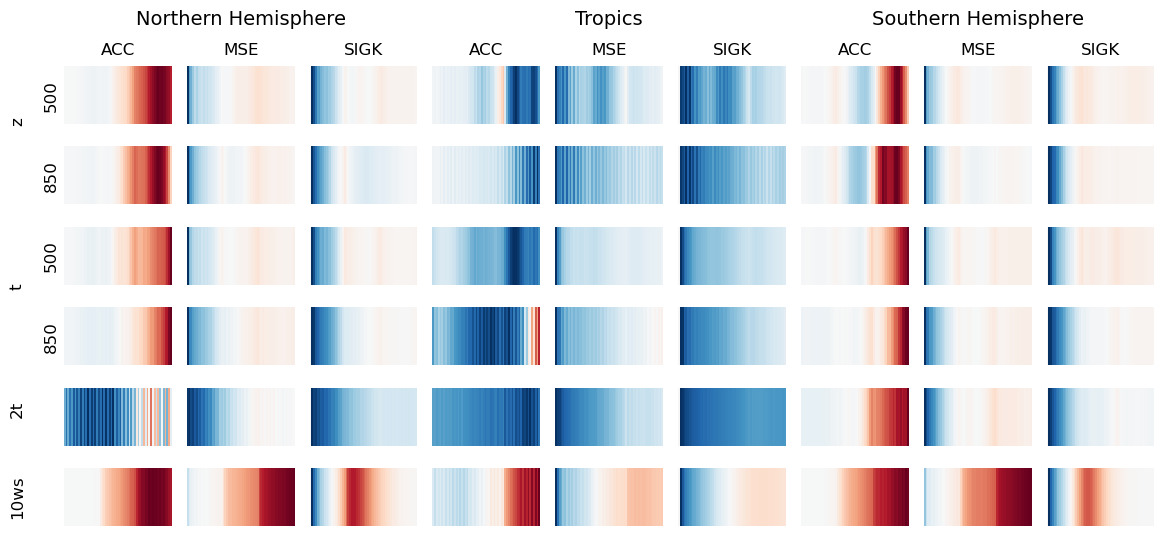

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE','SIGK']
levels = [500, 850]

# Set up the figure and gridspec layout
fig = plt.figure(figsize=(12, 6))  # Increased figure height to accommodate 6 rows
spec = gridspec.GridSpec(
    nrows=2 + len(levels) * 2 + 2,  # 2 header rows + 2 levels for geopotential + 2 levels for temperature + 2 rows for 2m_temperature and 10m_wind speed
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * (len(levels) * 2) + [1, 1]  # Adjust header height ratios and add more rows
)

# === Add region titles ===
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)

    # Add region title centered above its two metric columns
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14) #fontweight='bold'
    ax_region.axis('off')  # Remove axis from region title box

# === Add metric titles with lowered position ===
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        # Add the metric title manually with lowered vertical position
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, transform=ax_metric.transAxes) #fontweight='bold'
        ax_metric.axis('off')  # Remove axis from metric title box

# === Plot geopotential data ===
fig.text(0.04, 0.75, 'z', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            if metric_idx<2:
                geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    geopotential_plot_data = percentage_diffsigkernel[0,:,region_idx]
                else:
                    geopotential_plot_data = percentage_diffsigkernel[1,:,region_idx]

                #geopotential[metric_idx, region_idx, :, level_idx]
            data_for_plot = geopotential_plot_data[np.newaxis, :]
            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )
                

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# === Plot temperature data ===
fig.text(0.04, 0.475, 't', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2 + len(levels), col_idx])
            
            if metric_idx<2:
                temperature_plot_data = temperature[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    temperature_plot_data = percentage_diffsigkernel[2,:,region_idx]
                else:
                    temperature_plot_data = percentage_diffsigkernel[3,:,region_idx]


            data_for_plot = temperature_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2 + len(levels), 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# === Plot 2m_temperature data ===
fig.text(0.04, 0.27, '2t', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 2, col_idx])
        
        if metric_idx<2:
            temperature_2m_plot_data = m2_temperature[metric_idx, region_idx, :]
        else:
            temperature_2m_plot_data = percentage_diffsigkernel[4,:,region_idx]

        data_for_plot = temperature_2m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

# === Plot 10m_wind speed data ===
fig.text(0.04, 0.125, '10ws', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 3, col_idx])

        if metric_idx<2:
            wind_speed_10m_plot_data = m10_wind_speed[metric_idx, region_idx, :]
        else:
            wind_speed_10m_plot_data = percentage_diffsigkernel[5,:,region_idx]

        data_for_plot = wind_speed_10m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )


plt.tight_layout(rect=[0.05, 0.05, 1, 0.95]) 
plt.show()

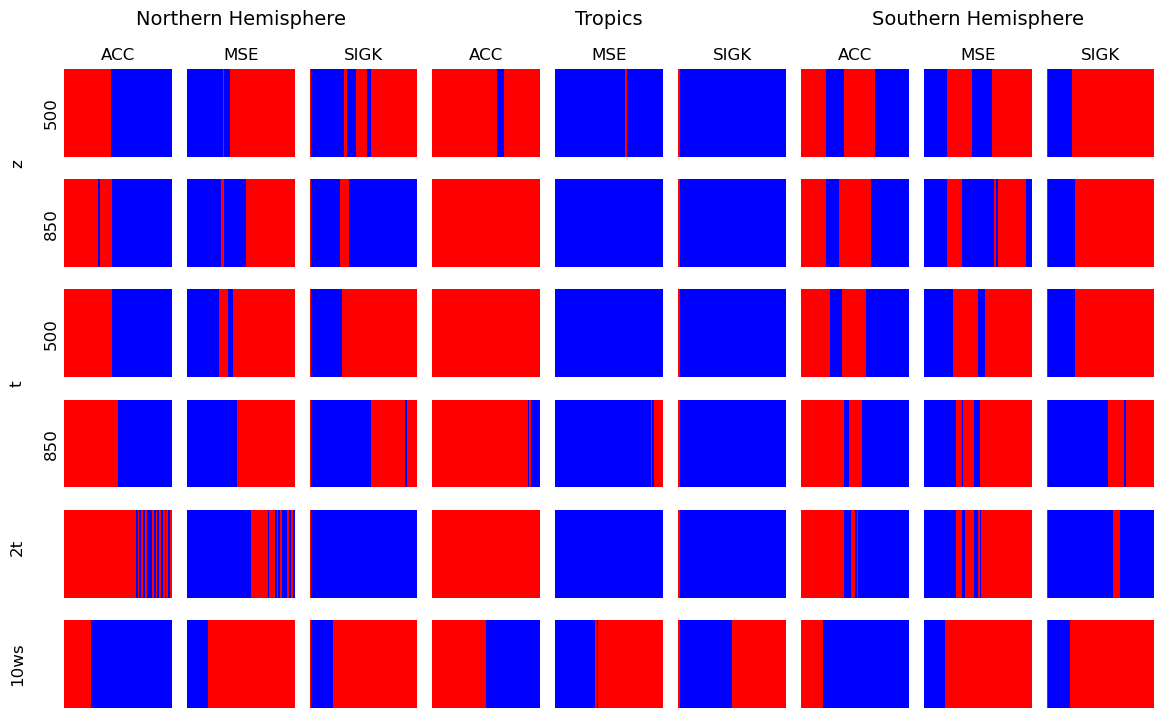

In [39]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# === Binary colormap: red for negative, blue for positive ===
cmap_binary = ListedColormap(['blue', 'red'])
norm_binary = BoundaryNorm([-np.inf, 0, np.inf], ncolors=cmap_binary.N)

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE','SIGK']
levels = [500, 850]

# Set up the figure and gridspec layout
fig = plt.figure(figsize=(12, 8))  # Increased figure height to accommodate 6 rows
spec = gridspec.GridSpec(
    nrows=2 + len(levels) * 2 + 2,  # 2 header rows + 2 levels for geopotential + 2 levels for temperature + 2 rows for 2m_temperature and 10m_wind speed
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * (len(levels) * 2) + [1, 1]  # Adjust header height ratios and add more rows
)

# === Add region titles ===
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14)
    ax_region.axis('off')

# === Add metric titles ===
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, transform=ax_metric.transAxes)
        ax_metric.axis('off')

# === Plot geopotential data ===
fig.text(0.04, 0.75, 'z', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            if metric_idx < 2:
                geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    geopotential_plot_data = percentage_diffsigkernel[0, :, region_idx]
                else:
                    geopotential_plot_data = percentage_diffsigkernel[1, :, region_idx]
                    
            data_for_plot = geopotential_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap=cmap_binary,
                norm=norm_binary,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off')

# === Plot temperature data ===
fig.text(0.04, 0.475, 't', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2 + len(levels), col_idx])
            
            if metric_idx < 2:
                temperature_plot_data = temperature[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    temperature_plot_data = percentage_diffsigkernel[2, :, region_idx]
                else:
                    temperature_plot_data = percentage_diffsigkernel[3, :, region_idx]

            data_for_plot = temperature_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap=cmap_binary,
                norm=norm_binary,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

    ax_label = fig.add_subplot(spec[level_idx + 2 + len(levels), 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off')

# === Plot 2m_temperature data ===
fig.text(0.04, 0.27, '2t', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 2, col_idx])
        
        if metric_idx < 2:
            temperature_2m_plot_data = m2_temperature[metric_idx, region_idx, :]
        else:
            temperature_2m_plot_data = percentage_diffsigkernel[4, :, region_idx]

        data_for_plot = temperature_2m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap=cmap_binary,
            norm=norm_binary,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

# === Plot 10m_wind speed data ===
fig.text(0.04, 0.125, '10ws', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 3, col_idx])
        
        if metric_idx < 2:
            wind_speed_10m_plot_data = m10_wind_speed[metric_idx, region_idx, :]
        else:
            wind_speed_10m_plot_data = percentage_diffsigkernel[5, :, region_idx]

        data_for_plot = wind_speed_10m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap=cmap_binary,
            norm=norm_binary,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95]) 
plt.show()


In [52]:
overallFUXItest = xr.concat(
    [
    overallFUXI,
    overallFUXI.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)
overallIFSENSEtest = xr.concat(
    [
    overallIFSENSE,
    overallIFSENSE.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)

percentage_difftest = (overallFUXItest - overallIFSENSEtest) / overallIFSENSEtest * 100
percentage_difftest=percentage_difftest.sel(metric=['acc','rmse'])

geopotentialtest = percentage_difftest['geopotential'].values
temperaturetest = percentage_difftest['temperature'].values
m2_temperaturetest = percentage_difftest['2m_temperature'].values
m10_wind_speedtest = percentage_difftest['10m_wind_speed'].values

# geopotential = percentage_diff['geopotential'].values
# geopotential.shape #now have normal array(metric =2, region =3, leadtime = 60, level =2)

# temperature = percentage_diff['temperature'].values
# m2_temperature = percentage_diff['2m_temperature'].values
# m10_wind_speed = percentage_diff['10m_wind_speed'].values

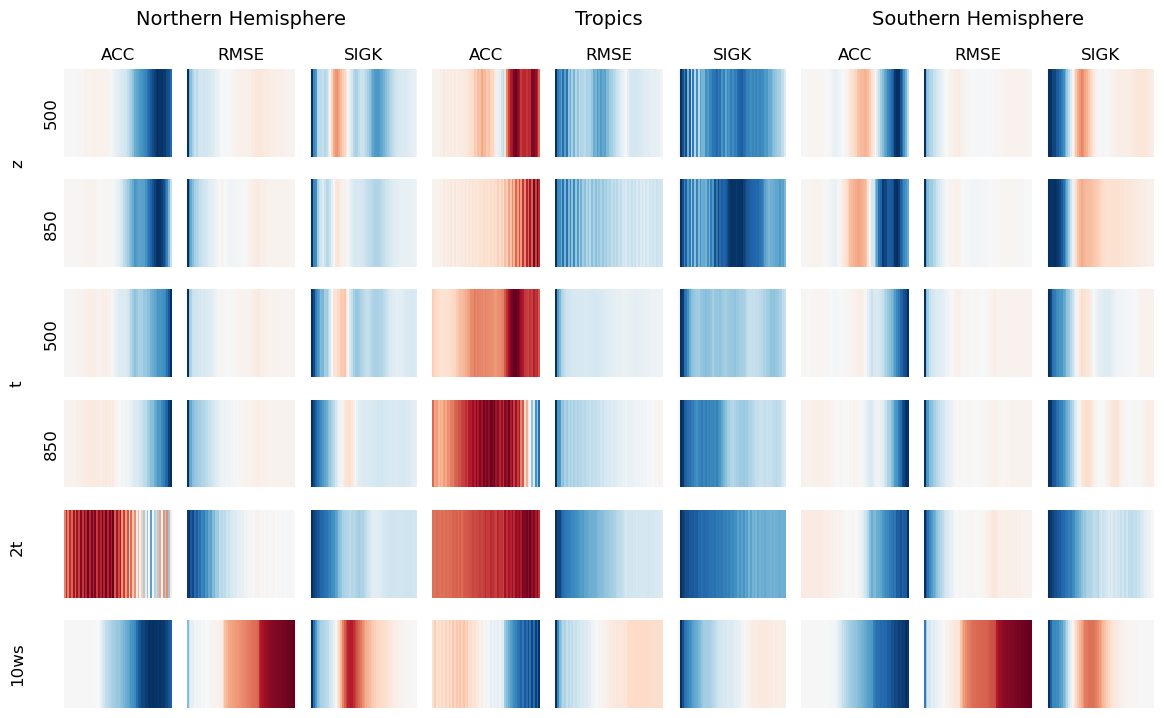

In [53]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

# Example data structure
regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'RMSE','SIGK']
levels = [500, 850]

# Set up the figure and gridspec layout
fig = plt.figure(figsize=(12, 8))  # Increased figure height to accommodate 6 rows
spec = gridspec.GridSpec(
    nrows=2 + len(levels) * 2 + 2,  # 2 header rows + 2 levels for geopotential + 2 levels for temperature + 2 rows for 2m_temperature and 10m_wind speed
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * (len(levels) * 2) + [1, 1]  # Adjust header height ratios and add more rows
)

# === Add region titles ===
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)

    # Add region title centered above its two metric columns
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14) #fontweight='bold'
    ax_region.axis('off')  # Remove axis from region title box

# === Add metric titles with lowered position ===
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        # Add the metric title manually with lowered vertical position
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, transform=ax_metric.transAxes) #fontweight='bold'
        ax_metric.axis('off')  # Remove axis from metric title box

# === Plot geopotential data ===
fig.text(0.04, 0.75, 'z', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            if metric_idx<2:
                geopotential_plot_data = geopotentialtest[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    geopotential_plot_data = percentage_diffsigkernel[0,:,region_idx]
                else:
                    geopotential_plot_data = percentage_diffsigkernel[1,:,region_idx]

                #geopotential[metric_idx, region_idx, :, level_idx]
            data_for_plot = geopotential_plot_data[np.newaxis, :]
            # Create heatmap without box boundaries
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )
                

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# === Plot temperature data ===
fig.text(0.04, 0.475, 't', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2 + len(levels), col_idx])
            
            if metric_idx<2:
                temperature_plot_data = temperaturetest[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    temperature_plot_data = percentage_diffsigkernel[2,:,region_idx]
                else:
                    temperature_plot_data = percentage_diffsigkernel[3,:,region_idx]


            data_for_plot = temperature_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

    # Add level labels to the first metric column of each row
    ax_label = fig.add_subplot(spec[level_idx + 2 + len(levels), 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off')  # Remove axis from level label box

# === Plot 2m_temperature data ===
fig.text(0.04, 0.27, '2t', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 2, col_idx])
        
        if metric_idx<2:
            temperature_2m_plot_data = m2_temperaturetest[metric_idx, region_idx, :]
        else:
            temperature_2m_plot_data = percentage_diffsigkernel[4,:,region_idx]

        data_for_plot = temperature_2m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

# === Plot 10m_wind speed data ===
fig.text(0.04, 0.125, '10ws', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 3, col_idx])

        if metric_idx<2:
            wind_speed_10m_plot_data = m10_wind_speedtest[metric_idx, region_idx, :]
        else:
            wind_speed_10m_plot_data = percentage_diffsigkernel[5,:,region_idx]

        data_for_plot = wind_speed_10m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave a bit of space for titles at the top
plt.show()